In [12]:
! py -m pip install mlxtend --upgrade

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.4.1 requires packaging<22.0,>=0.21, but you have packaging 23.2 which is incompatible.



  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 1.4/1.4 MB 23.2 MB/s eta 0:00:00
   ---------------------------------------- 11.1/11.1 MB 18.8 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.1.7
    Uninstalling mlxtend-0.1.7:
      Successfully uninstalled mlxtend-0.1.7


In [ ]:
import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import datetime, timedelta

# Setup
fake = Faker()
np.random.seed(42)
random.seed(42)

# -----------------------
# 1. Generate Customers
# -----------------------
num_customers = 100
customer_data = []

for i in range(1, num_customers + 1):
    is_male = random.choice([True, False])
    first_name = fake.first_name_male() if is_male else fake.first_name_female()
    last_name = fake.last_name()
    gender = 'M' if is_male else 'F'
    dob = fake.date_of_birth(minimum_age=18, maximum_age=75)
    age = (datetime.now().date() - dob).days // 365
    income = random.randint(20000, 150000)
    credit_score = int(np.clip(np.random.normal(loc=600 + (income / 1000), scale=50), 300, 850))

    customer_data.append({
        "Customer_ID": f"CUST{i:04d}",
        "First_Name": first_name,
        "Last_Name": last_name,
        "Gender": gender,
        "Date_of_Birth": dob,
        "Age": age,
        "Email": fake.email(),
        "Phone": fake.phone_number(),
        "Address": fake.address().replace("\n", ", "),
        "City": fake.city(),
        "State": fake.state(),
        "Postal_Code": fake.postcode(),
        "Country": "USA",
        "Annual_Income": income,
        "Credit_Score": credit_score
    })

df_customers = pd.DataFrame(customer_data)
df_customers.to_csv("customers.csv", index=False)

# ----------------------------
# 2. Generate Transactions
# ----------------------------
transaction_data = []
categories = ['Grocery', 'Fuel', 'Dining', 'Travel', 'Medical', 'Baby', 'Education', 'Entertainment', 'Home', 'Salary']
merchants = {
    'Grocery': ['Walmart', 'Whole Foods', 'Kroger'],
    'Fuel': ['Shell', 'Exxon', 'Chevron'],
    'Dining': ['McDonald\'s', 'Starbucks', 'Chipotle'],
    'Travel': ['Delta', 'Airbnb', 'Uber'],
    'Medical': ['CVS', 'Walgreens', 'Urgent Care'],
    'Baby': ['BabyGap', 'Target', 'Pampers Store'],
    'Education': ['Coursera', 'Udemy', 'University Bookstore'],
    'Entertainment': ['Netflix', 'AMC Theatres', 'Spotify'],
    'Home': ['Home Depot', 'Lowe\'s', 'IKEA'],
    'Salary': ['Company Payroll', 'Direct Deposit']
}

txn_id = 1
for customer in df_customers['Customer_ID']:
    num_txns = random.randint(5, 15)
    for _ in range(num_txns):
        category = random.choice(categories)
        merchant = random.choice(merchants[category])
        amount = round(random.uniform(10, 2000) if category != 'Salary' else random.uniform(3000, 10000), 2)
        date = datetime.now() - timedelta(days=random.randint(0, 28))
        
        transaction_data.append({
            "Transaction_ID": f"TXN{txn_id:06d}",
            "Customer_ID": customer,
            "Timestamp": date.strftime("%Y-%m-%d %H:%M:%S"),
            "Merchant": merchant,
            "Category": category,
            "Amount": amount,
            "Description": f"{category} - {merchant}"
        })
        txn_id += 1

df_transactions = pd.DataFrame(transaction_data)
df_transactions.to_csv("transactions.csv", index=False)

# -------------------------
# 3. Generate Product Table
# -------------------------



TypeError: Random.randint() takes 3 positional arguments but 4 were given

In [3]:
import pandas as pd

# Load CSVs
df_customers = pd.read_csv("customers.csv")
df_transactions = pd.read_csv("transactions.csv")

# Ensure timestamp is in datetime format
df_transactions["Timestamp"] = pd.to_datetime(df_transactions["Timestamp"])

# Filter only last 4 weeks of transactions
latest_date = df_transactions["Timestamp"].max()
cutoff_date = latest_date - pd.Timedelta(days=28)
df_recent = df_transactions[df_transactions["Timestamp"] >= cutoff_date]

# Aggregate features per customer
features = df_recent.groupby("Customer_ID").agg(
    Total_Spend=("Amount", "sum"),
    Num_Transactions=("Transaction_ID", "count"),
    Avg_Txn_Amount=("Amount", "mean"),
    Max_Txn_Amount=("Amount", "max"),
    Has_Salary_Credit=("Category", lambda x: int("Salary" in x.values))
).reset_index()

# Pivot category spend into separate columns
category_spend = df_recent.pivot_table(
    index="Customer_ID",
    columns="Category",
    values="Amount",
    aggfunc="sum",
    fill_value=0
).add_prefix("Spend_").reset_index()

# Merge with customer demographics
df_feature_store = (
    features
    .merge(category_spend, on="Customer_ID", how="left")
    .merge(df_customers[["Customer_ID", "Age", "Annual_Income", "Credit_Score"]], on="Customer_ID", how="left")
)

# Save to CSV
df_feature_store.to_csv("feature_store.csv", index=False)


In [67]:
import pandas as pd

# Full product list with detailed columns, plus structured eligibility fields
products = [
    # Product_ID, Name, Type, Tier,
    # Features_Benefits, Target_Behavior, Special_Offer,
    # min_age, min_income, min_credit_score
    ("P001", "Starter Credit Card", "Credit Card", "Low",
     "1% cashback on all purchases",
     "New credit users, low spenders",
     "USD 25 cashback on first USD 300 spend",
     None,       20000, 600),
    ("P002", "Everyday Saver", "Savings Account", "Low",
     "4% interest, no maintenance fees",
     "Customers starting savings",
     "USD 50 bonus for maintaining USD 1,000 balance for 3 months",
     None,       100,   None),
    ("P003", "Smart Shopper Card", "Credit Card", "Mid",
     "2% cashback on groceries & fuel",
     "High grocery and fuel spenders",
     "USD 50 cashback on first USD 500 spend",
     None,       30000, 650),
    ("P004", "Smart Budget Account", "Savings + Budget", "Mid",
     "5% APY on goal-based savings",
     "Budget-conscious savers",
     "Free premium budgeting tools for 6 months",
     None,       25000, None),
    ("P005", "Travel Rewards Elite", "Credit Card", "High",
     "3x travel points, lounge access",
     "Frequent travelers",
     "USD 200 travel voucher after USD 5,000 spend",
     None,       70000, 700),
    ("P006", "Elite Wealth Plan", "Investment", "High",
     "6–8% ROI, personal wealth advisor",
     "High-income professionals",
     "1% bonus returns for first year",
     30,         100000, None),
    ("P007", "Family Future Plan", "Insurance/Savings", "Mid-High",
     "Child savings + life insurance combo",
     "Families, new parents",
     "USD 100 bonus on first-year premium",
     25,         None,   None),
    ("P008", "Student Flex Account", "Savings", "Student",
     "No fees, education budgeting tools",
     "Students under 25",
     "USD 100 top-up on monthly deposits over USD 200",
     None,       None,   None),  # eligibility purely age<25
    ("P009", "Home Advantage Loan", "Loan", "Mid-High",
     "Low-interest home loans",
     "First-time home buyers",
     "Reduced interest rate for bundled insurance",
     None,       None,   None),
    ("P010", "Retirement Essentials", "Wealth + Health", "Senior",
     "Pension fund + health perks",
     "Customers over 60",
     "USD 500 wellness bonus for first year",
     60,         None,   None),
    ("P011", "FlexFuel Card", "Credit Card", "Low-Mid",
     "3% cashback on fuel",
     "Regular commuters",
     "USD 50 fuel voucher after USD 500 spend",
     None,       None,   None),
    ("P012", "Digital Nomad Saver", "Savings Account", "Mid",
     "1.5% bonus APY for international use",
     "Frequent travelers, remote workers",
     "No international transfer fees for 6 months",
     None,       None,   None),
    ("P013", "HealthSecure Plan", "Health + Savings", "Mid",
     "HSA integration, telehealth access",
     "Health-conscious individuals",
     "USD 200 credit toward medical expenses",
     None,       None,   None),
    ("P014", "GreenLife Investment", "ESG Investment", "Mid-High",
     "5–9% returns in sustainable funds",
     "Eco-conscious investors",
     "USD 100 green bonus + 0.5% bonus returns",
     None,       40000,  None),
    ("P015", "Weekend Explorer Card", "Credit Card", "Mid",
     "2.5% cashback on dining & entertainment",
     "Social and active lifestyle",
     "Free concert ticket after USD 2,000 spend",
     None,       400,    None),
    ("P016", "CashBuilder Certificate", "CD / Fixed Deposit", "Low-Mid",
     "4.75% fixed interest (6 months)",
     "Idle balance savers",
     "USD 25 bonus for auto-renewal",
     None,       5000,   None),
    ("P017", "Lifestyle Bundle Plus", "Bundle (3-in-1)", "High",
     "Credit + Wealth + Travel perks",
     "Affluent, multi-product users",
     "USD 300 statement credit + concierge onboarding",
     None,       100000, None),
    ("P018", "BabyStart Trust Plan", "Child Investment", "Mid",
     "Custodial account for education",
     "Parents with young children",
     "1st-year fees waived + USD 100 education bonus",
     None,       None,   None),
    ("P019", "MoveSmart Relocation Loan", "Loan", "Mid",
     "0% for 6 months, flexible repayment",
     "Customers with large recent spends",
     "USD 150 moving voucher",
     None,       5000,   None),
    ("P020", "SideHustle Account", "Business Checking", "Low-Mid",
     "No fees, invoice management",
     "Freelancers, side businesses",
     "USD 75 bonus for linking payment gateway",
     None,       None,   None),
]

# Create DataFrame with the new structured columns
columns = [
    "Product_ID", "Product_Name", "Product_Type", "Tier",
    "Features_Benefits", "Target_Behavior", "Special_Offer",
    "min_age", "min_income", "min_credit_score"
]

df_products = pd.DataFrame(products, columns=columns)

# Save to CSV (or load into your DB directly)
df_products.to_csv("products.csv", index=False)
print("✅ products.csv created with structured eligibility columns.")


✅ products.csv created with structured eligibility columns.


In [37]:
import pandas as pd

# Load data
df_transactions = pd.read_csv("transactions.csv")
df_customers = pd.read_csv("customers.csv")
df_feature_store = pd.read_csv("feature_store.csv")

# Ensure Timestamp is datetime
df_transactions["Timestamp"] = pd.to_datetime(df_transactions["Timestamp"])

# 1️⃣ Calculate Aggregation_Days per customer
agg_days = df_transactions.groupby("Customer_ID").agg(
    First_Txn_Date=("Timestamp", "min"),
    Last_Txn_Date=("Timestamp", "max")
)
agg_days["Aggregation_Days"] = (agg_days["Last_Txn_Date"] - agg_days["First_Txn_Date"]).dt.days + 1
agg_days = agg_days[["Aggregation_Days"]].reset_index()

# 2️⃣ Calculate Spend Variability (std deviation of Amount)
spend_var = df_transactions.groupby("Customer_ID").agg(
    Spend_Variability=("Amount", "std")
).fillna(0).reset_index()

# 3️⃣ Calculate Salary_to_Spend_Ratio
salary_spend = df_transactions.groupby(["Customer_ID", "Category"]).agg(Total_Category_Spend=("Amount", "sum")).reset_index()
salary = salary_spend[salary_spend["Category"] == "Salary"][["Customer_ID", "Total_Category_Spend"]].rename(columns={"Total_Category_Spend": "Total_Salary"})
total_spend = df_feature_store[["Customer_ID", "Total_Spend"]]

salary_ratio = pd.merge(total_spend, salary, on="Customer_ID", how="left").fillna(0)
salary_ratio["Salary_to_Spend_Ratio"] = salary_ratio["Total_Salary"] / salary_ratio["Total_Spend"]
salary_ratio = salary_ratio[["Customer_ID", "Salary_to_Spend_Ratio"]]

# 4️⃣ Top Spend Category
top_category = df_transactions[df_transactions["Category"] != "Salary"].groupby(["Customer_ID", "Category"]).agg(
    Category_Spend=("Amount", "sum")
).reset_index()

top_spend_cat = top_category.loc[top_category.groupby("Customer_ID")["Category_Spend"].idxmax()]
top_spend_cat = top_spend_cat[["Customer_ID", "Category"]].rename(columns={"Category": "Top_Spend_Category"})

# 5️⃣ Idle Balance Estimate
income = df_customers[["Customer_ID", "Annual_Income"]]
idle_balance = pd.merge(total_spend, income, on="Customer_ID", how="left")
idle_balance["Idle_Balance_Estimate"] = idle_balance["Annual_Income"] - idle_balance["Total_Spend"]
idle_balance = idle_balance[["Customer_ID", "Idle_Balance_Estimate"]]

# Merge all new features
df_enhanced = df_feature_store.merge(agg_days, on="Customer_ID", how="left")
df_enhanced = df_enhanced.merge(spend_var, on="Customer_ID", how="left")
df_enhanced = df_enhanced.merge(salary_ratio, on="Customer_ID", how="left")
df_enhanced = df_enhanced.merge(top_spend_cat, on="Customer_ID", how="left")
df_enhanced = df_enhanced.merge(idle_balance, on="Customer_ID", how="left")

# Fill any remaining NaNs
df_enhanced = df_enhanced.fillna({
    "Spend_Variability": 0,
    "Salary_to_Spend_Ratio": 0,
    "Top_Spend_Category": "Unknown",
    "Aggregation_Days": 28  # Default if only 1 txn
})

# Save enhanced feature store
df_enhanced.to_csv("feature_store_enhanced.csv", index=False)

print("✅ Enhanced feature_store_enhanced.csv created.")


✅ Enhanced feature_store_enhanced.csv created.


In [70]:
import pandas as pd
import random
from datetime import datetime, timedelta

# Load customer data and product catalog
df_customers = pd.read_csv("customers.csv")
df_products = pd.read_csv("products.csv")

# Prepare list to store ownership records
customer_products = []

# Define logic-based exclusions
def get_eligible_products(customer_row):
    age = customer_row['Age']
    eligible_products = df_products.copy()

    # Exclude Student Account for non-students
    if age > 25:
        eligible_products = eligible_products[eligible_products['Product_ID'] != 'P008']
    
    # Exclude Retirement plan for young customers
    if age < 55:
        eligible_products = eligible_products[eligible_products['Product_ID'] != 'P010']
    
    return eligible_products['Product_ID'].tolist()

# Helper to pick a random date in H1 2024
start_date = datetime(2024, 1, 1)
end_date   = datetime(2024, 6, 30)
delta_days = (end_date - start_date).days

def random_h1_2024_date():
    return (start_date + timedelta(days=random.randint(0, delta_days))).date()

# Generate ownership for each customer
for _, customer in df_customers.iterrows():
    cust_id = customer['Customer_ID']
    
    # Get eligible products
    eligible_products = get_eligible_products(customer)
    
    # Randomly assign 1 to 3 products
    owned_count = random.randint(1, 3)
    owned_products = random.sample(eligible_products, owned_count)
    
    for prod_id in owned_products:
        customer_products.append({
            "Customer_ID": cust_id,
            "Product_ID": prod_id,
            "Acquisition_Date": random_h1_2024_date().isoformat()
        })

# Create DataFrame
df_customer_products = pd.DataFrame(customer_products)

# Save to CSV
df_customer_products.to_csv("customer_products.csv", index=False)

print("✅ customer_products.csv created with Acquisition_Date in H1 2024.")



✅ customer_products.csv created with Acquisition_Date in H1 2024.


In [71]:
import pandas as pd
import sqlite3

# Load CSVs
df_customers = pd.read_csv("customers.csv")
df_transactions = pd.read_csv("transactions.csv")
df_products = pd.read_csv("products.csv")
df_feature_store = pd.read_csv("feature_store_enhanced.csv")  # From earlier step
df_customer_products = pd.read_csv("customer_products.csv")  # From earlier step

# Create SQLite DB
conn = sqlite3.connect("cross_selling.db")

# Write tables
df_customers.to_sql("customers", conn, if_exists="replace", index=False)
df_transactions.to_sql("transactions", conn, if_exists="replace", index=False)
df_products.to_sql("products", conn, if_exists="replace", index=False)
df_feature_store.to_sql("feature_store", conn, if_exists="replace", index=False)
df_customer_products.to_sql("customer_products", conn, if_exists="replace", index=False)

conn.close()
print("✅ Data loaded into cross_selling.db")


✅ Data loaded into cross_selling.db


## LLM

### Tools

In [1]:
import sqlite3
import pandas as pd
from langchain.agents import tool
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import AzureChatOpenAI
from prompts import *
import re
import joblib, pandas as pd, sqlite3, json
from langchain.agents import tool

# encoder = joblib.load("encoder.joblib")                 # one-time load

eligibility_df = pd.read_csv("products.csv").fillna({"excludes": ""})

conn = sqlite3.connect("cross_selling.db")

@tool
def fetch_customer_profile(name: str) -> str:
    """Fetch basic customer profile by full name."""
    df = pd.read_sql(f"SELECT * FROM customers WHERE First_Name || ' ' || Last_Name = '{name}'", conn)
    return df.to_json(orient="records") if not df.empty else "Customer not found."

@tool
def analyze_customer_behavior(customer_id: str) -> str:
    """Provides a detailed analysis of customer behavior, spending patterns, and financial signals."""
    df = pd.read_sql(f"SELECT * FROM feature_store WHERE Customer_ID = '{customer_id}'", conn)
    if df.empty:
        return "No behavior data found for this customer."
    
    row = df.iloc[0]
    insights = []

    # 1️⃣ Aggregation Period
    insights.append(f"Analysis based on {row['Aggregation_Days']} days of transaction data.")

    # 2️⃣ Spending Overview
    insights.append(f"Total spending during this period is ${row['Total_Spend']:.2f} across {row['Num_Transactions']} transactions.")
    insights.append(f"Average transaction amount is ${row['Avg_Txn_Amount']:.2f}, with a maximum single transaction of ${row['Max_Txn_Amount']:.2f}.")
    
    # 3️⃣ Key Spending Categories
    category_flags = []
    if row.get("Spend_Grocery", 0) > 500:
        category_flags.append(f"Grocery: ${row['Spend_Grocery']:.2f}")
    if row.get("Spend_Travel", 0) > 800:
        category_flags.append(f"Travel: ${row['Spend_Travel']:.2f}")
    if row.get("Spend_Fuel", 0) > 150:
        category_flags.append(f"Fuel: ${row['Spend_Fuel']:.2f}")
    if row.get("Spend_Medical", 0) > 200:
        category_flags.append(f"Medical: ${row['Spend_Medical']:.2f}")
    if row.get("Spend_Entertainment", 0) > 300:
        category_flags.append(f"Entertainment: ${row['Spend_Entertainment']:.2f}")

    if category_flags:
        insights.append("Significant spending detected in categories: " + "; ".join(category_flags))
    else:
        insights.append(f"Primary spending category is {row['Top_Spend_Category']}.")

    # 4️⃣ Income & Salary Patterns
    if row["Has_Salary_Credit"]:
        insights.append("Regular salary deposits detected, indicating stable income.")
    if row["Salary_to_Spend_Ratio"] > 0.5:
        insights.append(f"Healthy disposable income, with a Salary-to-Spend Ratio of {row['Salary_to_Spend_Ratio']:.2f}.")

    # 5️⃣ Financial Profile
    if row["Annual_Income"] > 100000:
        insights.append(f"High annual income: ${row['Annual_Income']}.")
    elif row["Annual_Income"] > 60000:
        insights.append(f"Moderate annual income: ${row['Annual_Income']}.")

    if row["Credit_Score"] >= 750:
        insights.append(f"Excellent credit score: {row['Credit_Score']}.")
    elif row["Credit_Score"] >= 700:
        insights.append(f"Good credit score: {row['Credit_Score']}.")
    else:
        insights.append(f"Credit score is {row['Credit_Score']}.")

    # 6️⃣ Spend Variability
    if row["Spend_Variability"] > 500:
        insights.append(f"High variability in spending, suggesting inconsistent transaction amounts.")
    else:
        insights.append(f"Consistent spending behavior with low variability.")

    # 7️⃣ Idle Balance Potential
    if row["Idle_Balance_Estimate"] > 5000:
        insights.append(f"Estimated idle balance of ${row['Idle_Balance_Estimate']:.2f}, indicating potential for savings or investment products.")

    return " | ".join(insights)

@tool
def fetch_product_catalog(dummy_input: str) -> str:
    """Returns the bank's product catalog for cross-selling."""
    df = pd.read_sql("SELECT * FROM products", conn)
    return df.to_json(orient="records")


@tool
def scientific_calculator(expression: str) -> str:
    """Performs safe scientific calculations. Provide expressions like '1250 / 28' or 'sqrt(256)'."""
    import math
    allowed_names = {k: v for k, v in math.__dict__.items() if not k.startswith("__")}
    allowed_names['abs'] = abs

    try:
        result = eval(expression, {"__builtins__": {}}, allowed_names)
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error in calculation: {str(e)}"

@tool
def fetch_owned_products(customer_id: str) -> str:
    """
    Fetches the list of products currently owned by the customer.
    The LLM should avoid recommending these products again.
    """
    query = f"""
            SELECT p.Product_ID, p.Product_Name, p.Product_Type
            FROM customer_products cp
            JOIN products p ON cp.Product_ID = p.Product_ID
            WHERE cp.Customer_ID = '{customer_id}'
        """
    df = pd.read_sql(query, conn)
    
    if df.empty:
        return "This customer does not own any products currently."
    
    # Return a readable list
    owned_list = df[['Product_ID', 'Product_Name', 'Product_Type']].to_dict(orient='records')
    return f"Customer currently owns the following products: {owned_list}"

@tool
def fetch_schema_info(dummy_input: str = "") -> str:
    """
    Returns the pre‐built SCHEMA_INFO string describing your database schema.
    """
    return SCHEMA_INFO


@tool
def run_sql(sql_statements: str) -> str:
    """
    Executes one or more semicolon-separated SQL statements against `conn`.
    - SELECT queries: returns top 5 rows as a markdown table.
    - Other queries: returns success/failure status.
    """
    outputs = []
    for stmt in sql_statements.split(";"):
        stmt = stmt.strip()
        if not stmt:
            continue
        try:
            if stmt.lower().startswith("select"):
                df = pd.read_sql(stmt, conn)
                if df.empty:
                    outputs.append(f"✅ `{stmt}` returned no rows.")
                else:
                    table = df.to_markdown(index=False)
                    outputs.append(f"✅ Results for `{stmt}`:\n\n{table}")
            else:
                conn.execute(stmt)
                conn.commit()
                outputs.append(f"✅ Executed `{stmt}` successfully.")
        except Exception as e:
            outputs.append(f"❌ Error executing `{stmt}`:\n{str(e)}")
    return "\n\n".join(outputs)

@tool
def clean_sql_statement(raw_sql: str) -> str:
    """
    Strips out markdown fences (```sql``` or ```), any leading/trailing backticks,
    and excessive whitespace so you get a clean SQL string.
    """
    # Remove opening fences like ```sql or ``` and closing ```
    cleaned = re.sub(r"```(?:sql)?\s*", "", raw_sql)
    cleaned = cleaned.replace("```", "")
    # Collapse any multiple newlines/spaces
    cleaned = re.sub(r"\s*\n\s*", " ", cleaned)
    # Remove trailing semicolon if desired (we’ll handle semis in run_sql)
    cleaned = cleaned.strip().rstrip(";")
    return cleaned
    


## Segment Rate scorer

In [ ]:
import json, pandas as pd

# --- one-time loads ---------------------------------------------
seg_map = pd.read_csv("segment_map.csv").set_index("Customer_ID")["segment"]
takeup  = pd.read_parquet("segment_takeup.parquet")

@tool
def segment_rate_score(input: str) -> str:
    """
    JSON  {"customer_id": "...", "product_ids": [...]}  →
    JSON  {"P003": 0.071, "P005": 0.018, ...}
    Uses k-means clusters built from rich behavioural features.
    """
    req  = json.loads(input)
    cid  = req["customer_id"]
    pids = req["product_ids"]

    if cid not in seg_map:
        return json.dumps({p:0.0 for p in pids})

    seg = int(seg_map[cid])
    if seg not in takeup.index:
        return json.dumps({p:0.0 for p in pids})

    rates = takeup.loc[seg]
    return json.dumps({p: round(float(rates.get(p,0.0)),3) for p in pids})



## Eligibility Tool

In [ ]:
@tool
def filter_eligible_products(input: str) -> str:
    """
    Input  ► JSON {"customer_id": "...", "product_ids": ["P003","P005",...]}
    Output ► JSON {"eligible": [...], "ineligible": {product: reason, ...}}
    Deterministic screen using `eligibility_rules.csv` + already-owned check.
    """
    import json, pandas as pd
    payload = json.loads(input)
    cid     = payload["customer_id"]
    cands   = payload["product_ids"]

    cust    = pd.read_sql(f"SELECT Age, Annual_Income, Credit_Score "
                          f"FROM customers WHERE Customer_ID='{cid}'", conn).iloc[0]
    owned   = pd.read_sql(f"SELECT Product_ID FROM customer_products "
                          f"WHERE Customer_ID='{cid}'", conn)["Product_ID"].tolist()

    rules   = eligibility_df.set_index("Product_ID").loc[cands]
    eligible, ineligible = [], {}
    for pid, row in rules.iterrows():
        fails = []
        if pd.notna(row.min_age)          and cust.Age          < row.min_age:          fails.append("age")
        if pd.notna(row.min_income)       and cust.Annual_Income< row.min_income:       fails.append("income")
        if pd.notna(row.min_credit_score) and cust.Credit_Score < row.min_credit_score: fails.append("credit")

        excl = row.get("excludes", "")
        if excl and any(o in excl.split(",") for o in owned):
            fails.append("exclusion_conflict")

        if pid in owned:
            fails.append("already_owned")

        if fails:
            ineligible[pid] = ",".join(fails)
        else:
            eligible.append(pid)
    return json.dumps({"eligible": eligible, "ineligible": ineligible})


## Lift Score

In [ ]:
import json, pandas as pd, sqlite3
from langchain.agents import tool

# DB connection reused by all tools
conn = sqlite3.connect("cross_selling.db", check_same_thread=False)

# ---------- association rules JSON ---------------
with open("synergy_rules.json", "r") as f:
    raw_rules = json.load(f)

# Convert lists → sets for fast lookup
rules = [
    {
        "antecedents": set(r["antecedents"]),
        "consequents": set(r["consequents"]),
        "lift": float(r["lift"])
    }
    for r in raw_rules
]

# ---------- cache customer->owned products -------
customer_owned = (
    pd.read_sql("SELECT Customer_ID, Product_ID FROM customer_products", conn)
      .groupby("Customer_ID")["Product_ID"].agg(list)
      .to_dict()
)


In [18]:
@tool
def lift_score(input: str) -> str:
    """
    Input  ►  JSON {"customer_id": "...",
                    "product_ids": ["P003","P005",...]}
    Output ►  JSON {"P003": 1.82, "P005": 1.00, ... }

    • Uses pre-computed association rules (Apriori) to measure how strongly
      each candidate pairs with ANY product the customer already owns.
    • Score = maximum lift; returns 1.00 if no rule exists.
    """
    pl    = json.loads(input)
    cid   = pl["customer_id"]
    cands = pl["product_ids"]

    owned = customer_owned.get(cid, [])
    scores = {}

    for pid in cands:
        lifts = [
            r["lift"]
            for r in rules
            if (pid in r["consequents"]
                and any(o in r["antecedents"] for o in owned))
        ]
        scores[pid] = round(max(lifts) if lifts else 1.00, 3)

    return json.dumps(scores)


### Tool Descriptions

In [ ]:
fetch_customer_profile.description = "Fetch the customer's demographic and financial profile by full name."

fetch_product_catalog.description = "Retrieve the complete product catalog including features, target behaviors, eligibility criteria, and special offers."

fetch_owned_products.description = "Get a list of products already owned by the customer to avoid duplicate recommendations."

scientific_calculator.description = "Perform numeric calculations such as averages, ratios, or thresholds to support financial reasoning."

fetch_schema_info.description = (
    "Use this tool to retrieve the database schema (tables, columns, types) "
    "Use this tool for any doubts with tables"
)

run_sql.description = (
    "Use this tool to execute raw SQL statements. "
    "Accepts one or multiple semicolon-separated queries. "
    "Use this tool to resolve data related doubts in Thoughts"
    "use fetch_schema tool before using this tool"
)

analyze_customer_behavior.description = (
    "► Purpose\n"
    "    Produce a concise, machine-readable snapshot of a customer’s "
    "behavioural KPIs for recommendation reasoning.\n\n"
    "► When to call\n"
    "    • You ALREADY have the Customer_ID.\n"
    "    • You need overall spend totals, top category, idle balance, etc.\n"
    "    • NOT for raw transaction queries or SQL look-ups.\n\n"
    "► Input\n"
    "    The single Customer_ID as a plain string (e.g. \"CUST0008\").\n\n"
    "► Output\n"
    "    JSON summary, e.g. "
    "{\"Total_Spend\": 9453.12, \"Top_Spend_Category\": \"Grocery\", "
    "\"Idle_Balance_Est\": 1100.0, \"Aggregation_Days\": 60 }.\n"
)


clean_sql_statement.description = (
    "Use this tool to take any raw SQL (even wrapped in markdown fences) "
    "and return a single clean SQL string, ready for execution." )

filter_eligible_products.description = (
    "► Purpose\n"
    "    Hard-screen a list of candidate product IDs, removing anything the customer "
    "    is not legally or sensibly allowed to open.\n\n"
    "► When to call\n"
    "    • Right after you generate (or retrieve) a pool of potential offers.\n"
    "    • BEFORE you run propensity models or bundle optimizers.\n\n"
    "► Rule set\n"
    "    Uses a pre-loaded products.csv (min_age, min_income, "
    "    min_credit_score, excludes list) **and** the customer's existing holdings "
    "    to decide eligibility deterministically."
)

lift_score.description = (
    "► Purpose\n"
    "    Estimate how well each CANDIDATE product pairs with the customer's "
    "    EXISTING portfolio, using historical association-rule lift.\n\n"
    "► When to call\n"
    "    • You already know customer_id and a list of ELIGIBLE products.\n"
    "    • You want to rank or boost products that have strong co-purchase "
    "      history with what the customer already owns.\n\n"
    "► Input  (JSON string)\n"
    "    {\"customer_id\": \"CUST0012\", "
    "     \"product_ids\": [\"P003\",\"P006\",\"P014\"] }\n\n"
    "► Output (JSON string)\n"
    "    {\"P003\": 1.82, \"P006\": 1.00, \"P014\": 2.07}\n\n"
    "► Notes\n"
    "    • A score >1 means the product historically appears MORE often with "
    "      the customer's owned items than by chance.\n"
    "    • A score =1 means no observed lift (neutral)."
)

segment_rate_score.description = (
    "► Purpose\n"
    "    Look up the HISTORICAL take-up probability for one or more candidate "
    "products, using the customer’s k-means behavioural cluster (8 clusters).\n\n"
    "► When to call\n"
    "    • You already know the customer_id AND a list of candidate product_ids.\n"
    "    • You need a quick probability proxy BEFORE ranking or bundling.\n\n"
    "► Input (JSON string)\n"
    "    {\"customer_id\": \"CUST0008\", "
    "     \"product_ids\": [\"P003\", \"P005\", \"P014\"] }\n\n"
    "► Output (JSON string)\n"
    "    {\"P003\": 0.071, \"P005\": 0.018, \"P014\": 0.042 }\n\n"
    "► Notes for the LLM\n"
    "    • Pass EXACTLY those two keys: customer_id, product_ids.\n"
    "    • If a product_id is missing from the segment table, the tool returns 0.0.\n"
)

lift_score.description = (
    "► Purpose\n"
    "    Estimate how well each CANDIDATE product pairs with the customer's "
    "    EXISTING portfolio, using historical association-rule lift.\n\n"
    "► When to call\n"
    "    • You already know customer_id and a list of ELIGIBLE products.\n"
    "    • You want to rank or boost products that have strong co-purchase "
    "      history with what the customer already owns.\n\n"
    "► Input  (JSON string)\n"
    "    {\"customer_id\": \"CUST0012\", "
    "     \"product_ids\": [\"P003\",\"P006\",\"P014\"] }\n\n"
    "► Output (JSON string)\n"
    "    {\"P003\": 1.82, \"P006\": 1.00, \"P014\": 2.07}\n\n"
    "► Notes\n"
    "    • A score >1 means the product historically appears MORE often with "
    "      the customer's owned items than by chance.\n"
    "    • A score =1 means no observed lift (neutral)."
)


In [6]:
# OPENAI_DEPLOYMENT_ENDPOINT = "https://az-openai-document-question-answer-service.openai.azure.com/" 
# OPENAI_API_KEY = "5d24331966b648738e5003caad552df8" 
# OPENAI_API_VERSION = "2023-05-15"

# OPENAI_DEPLOYMENT_NAME = "az-gpt_35_model"
# OPENAI_MODEL_NAME="gpt-3.5-turbo"

# OPENAI_ADA_EMBEDDING_DEPLOYMENT_NAME = "az-embedding_model" 
# OPENAI_ADA_EMBEDDING_MODEL_NAME = "text-embedding-ada-002"

# encoding_name = "cl100k_base"

# llm = AzureChatOpenAI(
#                         temperature=0.1,
#                         deployment_name=OPENAI_DEPLOYMENT_NAME,
#                         model_name=OPENAI_MODEL_NAME,
#                         azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT,
#                         openai_api_version=OPENAI_API_VERSION,
#                         openai_api_key=OPENAI_API_KEY            
#                     )

In [7]:
from dotenv import load_dotenv
import os, openai

load_dotenv()          # reads .env into os.environ
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")


OPENAI_DEPLOYMENT_ENDPOINT = "https://advancedanalyticsopenaikey.openai.azure.com/" 
OPENAI_API_VERSION = "2024-12-01-preview"

OPENAI_DEPLOYMENT_NAME = "gpt-4o"
OPENAI_MODEL_NAME="gpt-4o"


llm = AzureChatOpenAI(
                        temperature=0.1,
                        deployment_name=OPENAI_DEPLOYMENT_NAME,
                        model_name=OPENAI_MODEL_NAME,
                        azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT,
                        openai_api_version=OPENAI_API_VERSION,
                        openai_api_key=OPENAI_API_KEY            
                    )

In [8]:
from langchain.agents.format_scratchpad.openai_tools import format_to_openai_tool_messages
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents import AgentExecutor, create_react_agent
import textwrap

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", react_prompt),
        ("user", "{input}"),
        ("ai", "{agent_scratchpad}"),
    ]
)

# tools = [fetch_customer_profile, analyze_customer_behavior, fetch_product_catalog, fetch_owned_products, fetch_schema_info, run_sql ,clean_sql_statement ]
tools = [fetch_schema_info, run_sql  , clean_sql_statement,analyze_customer_behavior,filter_eligible_products,segment_rate_score]

agent = create_react_agent(
    llm=llm,
    tools=tools,
    prompt=prompt   # Optional. If omitted, uses LangChain's default ReAct prompt
)

# 4. Agent Executor
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
    return_intermediate_steps=True
)



# Pretty print with wrapping at 100 characters



In [9]:
def format_recommendation_summary(raw_text):
    # Remove initial label if present
    raw_text = raw_text.replace("**Recommendation Summary:**", "").strip()

    # Split by numbering (assuming '1.' and '2.' structure)
    parts = raw_text.split(" 2. ")
    rec_1 = parts[0].strip()
    rec_2 = parts[1].strip() if len(parts) > 1 else ""

    formatted_output = ""

    for idx, rec in enumerate([rec_1, rec_2], start=1):
        if not rec:
            continue
        # Split the recommendation into lines by bullet points
        lines = rec.split(" - ")
        title = lines[0].strip()
        bullets = lines[1:]

        formatted_output += f"{idx}. {title}\n"
        for bullet in bullets:
            bullet = bullet.replace("Eligibility Criteria", "Eligibility Criteria") \
                           .replace("Reason", "Reason") \
                           .replace("Benefit", "Benefit")
            formatted_output += f"   - {bullet.strip()}\n"
        formatted_output += "\n"

    return textwrap.dedent(formatted_output)

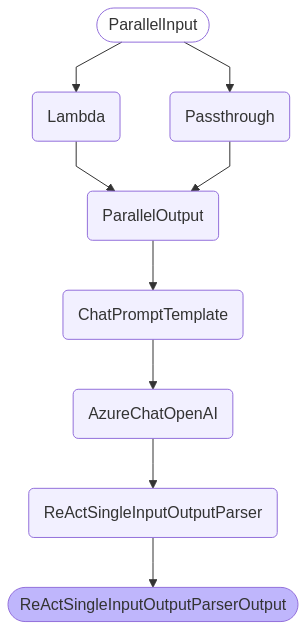

In [10]:
from IPython.display import display, Image
# 4) Visualize its reasoning graph (mermaid)
display(
    Image(
        agent
        .get_graph()
        .draw_mermaid_png()
    )
)

# Q&A

In [16]:
# user_query = "How much did David Brown spend in total over how many days? are there any outliers that stand out ?"
# user_query = "Recommend products for Kevin Fleming based on his current products and expenditures."
# user_query = "is Kevin Fleming Eligible for Elite Wealth Plan? explain why"
# user_query = "Give me a view of all transactions by David Brown"
# user_query = "Give me customer info for Mr.Fleming"
# user_query = "How many total customers bought more than 2 products ?"
# user_query = "Analyze Kevin Fleming's spending patterns. Which products did they buy ? What was the highest expenditure on?"
# user_query = "Give a distribution of customers by states"
# user_query = "Based on peers, what is the historical adoption rate for the Smart Shopper Card and Everyday Saver among customers like Austin Jones?"

# user_query = "For Austin Jones’s segment, please rank the top 3 products by take-up probability."

# user_query = "How likely is someone in David Brown’s age-and-income bracket to open the Travel Rewards Elite card?"

# user_query = "Give me the peer-segment adoption rates for P003, P005 and P014 for David Brown."

# user_query = "Among customers similar to Richard White, which product has the highest historical uptake: Weekend Explorer Card or GreenLife Investment?"

# user_query = "Rank the top five products by segment take-up rate for Richard White."

# user_query = "Show the probability, based on his behavioural cluster, that Kevin Fleming will buy Smart Shopper Card, Family Future Plan, or CashBuilder Certificate."

user_query = "What is the historical segment adoption rate for the Elite Wealth Plan for customers like Kevin Fleming?"

# user_query = "For Carla Meyer’s peer segment, list the three products with the greatest adoption probabilities."

# user_query = "Compare the segment-level likelihoods that Carla Meyer would open the FlexFuel Card versus the Digital Nomad Saver."


response = agent_executor.invoke({"input": user_query})



> Entering new AgentExecutor chain...
To determine the historical segment adoption rate for the Elite Wealth Plan for customers like Kevin Fleming, I need to:

1. Identify Kevin Fleming's customer ID.
2. Retrieve the product ID for the Elite Wealth Plan.
3. Use Kevin Fleming's customer ID and the product ID to query the segment adoption rate.

Let me start by finding Kevin Fleming's customer ID.Invalid Format: Missing 'Action:' after 'Thought:'I need to retrieve Kevin Fleming's customer ID from the database. 

Action: run_sql
Action Input: SELECT customer_id FROM customers WHERE name = 'Kevin Fleming';❌ Error executing `SELECT customer_id FROM customers WHERE name = 'Kevin Fleming'`:
Execution failed on sql 'SELECT customer_id FROM customers WHERE name = 'Kevin Fleming'': no such column: nameIt seems the column name for customer identification isn't clear. I need to check the database schema to confirm the correct column names for retrieving Kevin Fleming's customer ID.

Action: fetc

In [17]:
output_text = response.get('output', '')
print(format_recommendation_summary(output_text))

1. The historical segment adoption rate for the Elite Wealth Plan for customers like Kevin Fleming is 7.7%.


